# Processing and Correcting NEON Hyperspectral Flight Lines for Scalable Spectral Data Analysis

Welcome to this vignette! This guide provides a detailed walkthrough for processing NEON (National Ecological Observatory Network) flight line data, taking you from raw downloads to actionable outputs. The workflow includes converting raw NEON flight lines into ENVI-compatible formats, applying essential data corrections (such as topographic and BRDF adjustments), and extracting hyperspectral data to build comprehensive tables for numerical and statistical analysis.

This workflow has been carefully designed to address the challenges of processing large datasets, ensuring efficient memory usage and high data integrity, even within the constraints of a machine with 250 GB of RAM. By the end of this guide, you will have the tools and understanding to transform raw hyperspectral data into corrected, high-quality datasets ready for advanced ecological and environmental research.

---

## Table of Contents
1. [Introduction](#1-introduction)
2. [Prerequisites](#2-prerequisites)
3. [Environment Setup](#3-environment-setup)
4. [Understanding NEON Flight Lines](#4-understanding-neon-flight-lines)
5. [Finding NEON Flight Codes](#5-finding-neon-flight-codes)
6. [Running the `jefe` Function](#6-running-the-jefe-function)
7. [Handling Large Data Processing](#7-handling-large-data-processing)
8. [Extracting Data and Building Tables](#8-extracting-data-and-building-tables)
9. [Workarounds for RAM Limitations](#9-workarounds-for-ram-limitations)
10. [Conclusion](#10-conclusion)
11. [References](#11-references)

---

## 1. Introduction

Hyperspectral data collected through NEON (National Ecological Observatory Network) flight lines provides a high-resolution spectral view of the Earth's surface, capturing detailed information about vegetation, soils, water, and other environmental components. However, the raw NEON data comes in specialized formats that require processing and correction before they can be used for meaningful analysis. 

This vignette provides a detailed, step-by-step guide to download, convert, and process NEON flight line data, ensuring efficient memory usage and high data integrity throughout the workflow. Along the way, we will create specific file types needed for both corrections and analysis, bridging the gap between raw hyperspectral data and actionable insights.

---

### **Why Extract Hyperspectral Signals?**
Hyperspectral data is invaluable for ecological and environmental research as it provides detailed spectral signatures across hundreds of bands. By extracting these signals and applying corrections, researchers can:
- **Translate Patterns Across Scales:** Connect fine-scale field measurements to broader regional or global observations.
- **Quantify Environmental Changes:** Monitor vegetation health, water quality, or land cover changes over time.
- **Improve Decision-Making Tools:** Build robust models for ecological resilience, biodiversity, and conservation planning.

---

### **Applications of This Workflow**

This workflow is particularly suited for:
- **Scaling Insights Across Spatial Domains:** Translating fine-scale hyperspectral data to broader landscapes ensures consistency and comparability across scales.
- **Monitoring Environmental Changes:** Creating corrected and high-fidelity datasets to track vegetation health, water quality, or land cover over time.
- **Enabling Cross-Sensor Calibration:** Harmonizing hyperspectral data across platforms by applying consistent corrections and resampling techniques.

---

## 2. Prerequisites

Before you begin, ensure you have the following:

- **Hardware Requirements:**
  - A machine with at least **250 GB RAM** to handle large datasets efficiently.

- **Software Requirements:**
  - Access to a pre-configured Python environment with necessary libraries installed, including:
    - `geopandas`, `rasterio`, `pandas`, `numpy`, `hytools`, `scikit-learn`, `matplotlib`, `requests`, `h5py`, `ray`.

- **Data Requirements:**
  - NEON flight line data.
  - Corresponding flight codes to identify and process the relevant flight lines.

- **Additional Tools:**
  - A Jupyter Notebook interface to follow this vignette step by step.

---

## 3. Python Setup

To follow this vignette, you'll need a Python environment configured with the necessary dependencies. If you haven't set up your environment yet, follow the steps below to install the required tools and libraries. This guide assumes you are working in a Jupyter Notebook.

### Required Libraries
Ensure the following libraries are available in your environment:

In [7]:
import hytools as ht
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import nbconvert
import time

In [8]:
pip install spectral

Note: you may need to restart the kernel to use updated packages.


In [10]:
### Loading Earth Lab Spectral Tools

# 1. Enable autoreload in your Jupyter Notebook:

%load_ext autoreload
%autoreload 2

# 2. Import the custom tools module:

import spectral_unmixing_tools_original as el_spectral

# 3. Verify that the tools loaded correctly by printing the module's directory:

print(dir(el_spectral))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['CRS', 'ENVIProcessor', 'GradientBoostingRegressor', 'Resampling', '__builtins__', '__cached__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'apply_topo_and_brdf_corrections', 'boosted_quantile_plot', 'boosted_quantile_plot_by_sensor', 'box', 'calculate_default_transform', 'clean_csv_files_in_subfolders', 'clean_data_and_write_to_csv', 'concatenate_sensors', 'control_function', 'download_neon_file', 'download_neon_flight_lines', 'extract_overlapping_layers_to_2d_dataframe', 'find_raster_files', 'fit_models_with_different_alpha', 'flight_lines_to_envi', 'generate_config_json', 'generate_correction_configs', 'generate_correction_configs_for_directory', 'get_spectral_data_and_wavelengths', 'glob', 'go_forth_and_multiply', 'gpd', 'h5py', 'ht', 'jefe', 'json', 'load_and_combine_rasters', 'load_spectra', 'mask', 'mask_raster_with_polygons', 'np', 'open_image', 'os', 'pd', 'plot_each_


## 4. Understanding and Finding NEON Flight Lines

NEON flight lines are aerial survey paths designed to collect high-resolution spectral data across various ecological sites. These datasets are vital for studying vegetation, soil, water bodies, and other environmental parameters, forming the foundation for many ecological and environmental analyses.

### **How to Find Flight Codes**
To process NEON flight lines with the `jefe` function, you’ll need the flight codes corresponding to your desired data. Follow these steps to find them:
1. **Access the NEON Data Portal:** Visit the [NEON Data Portal](https://data.neonscience.org/) to browse available datasets.
2. **Navigate to Flight Line Data:** Locate the section for flight line spectral data at your site of interest.
3. **Identify Relevant Flight Codes:** Each flight line has associated metadata, including its unique flight code. Record the codes for the lines you wish to process.

### **Important Considerations**
1. **Data Availability:**
   - NEON’s Airborne Observation Platform (AOP) data is generally available 60 days after the last collection day at a site.
   - Data collection schedules may shift due to weather or logistical factors. For the latest updates, consult the [NEON Flight Schedules and Coverage page](https://www.neonscience.org/data-collection/flight-schedules-coverage).

2. **Data Quality Updates:**
   - NEON regularly updates its data products to address quality concerns or implement new processing methods.
   - Stay informed about updates or changes that could affect your datasets by checking the [AOP Data Availability Notification](https://www.neonscience.org/impact/observatory-blog/aop-data-availability-notification-release-2024).

---

## 5. Running the `jefe` Function

The `jefe` function orchestrates the entire workflow, including converting flight lines into appropriate file formats, applying corrections, and extracting pixel data to build tables.

### Parameters for `jefe`

To effectively utilize the `jefe` function for processing NEON flight line data, it's crucial to understand and accurately specify its parameters. Below is a detailed guide on each parameter, including how to obtain the necessary information.

#### **`base_folder` (str)**
- **Description:** The directory where output files will be stored.
- **How to Specify:** Choose or create a directory path on your local system where you want the processed data to be saved.

#### **`site_code` (str)**
- **Description:** The NEON site code representing the specific field site.
- **How to Find:**
  - NEON assigns unique four-letter codes to each field site (e.g., "NIWO" for Niwot Ridge).
  - You can find these codes on the [NEON Field Sites page](https://www.neonscience.org/field-sites/explore).

#### **`product_code` (str)**
- **Description:** The NEON data product code identifying the specific data product.
- **How to Find:**
  - NEON data products have unique identifiers (e.g., "DP1.30003.001" for discrete return LiDAR point cloud data).
  - Browse the [NEON Data Products Catalog](https://data.neonscience.org/data-products/explore) to locate the product code relevant to your research.

#### **`year_month` (str)**
- **Description:** The year and month of data collection in `'YYYY-MM'` format.
- **How to Determine:**
  - Data collection periods vary by site and product. Consult the [NEON Data Availability page](https://data.neonscience.org/visualizations/data-availability) to check when data was collected for your site and product of interest.
  - **Important Note:** Data availability is subject to change due to factors like weather conditions and program planning adjustments.

#### **`flight_lines` (list)**
- **Description:** A list of flight line codes to process.
- **How to Find:**
  - Flight line codes correspond to specific aerial survey paths.
  - Access the [NEON Data Portal](https://data.neonscience.org/) and navigate to the desired data product and site.
  - Flight line codes are typically listed in the metadata associated with each dataset.

---




### Example Usage

In [ ]:
# el jefe takes 3-5 hours to run and it creates a lot of files. You should have 200+GB of RAM and Storage available.
base_folder = "Next_try"
site_code = 'NIWO'
product_code = 'DP1.30006.001'
year_month = '2020-08'
flight_lines = [
     'D13_NIWO_DP1_20200801_161441',
        'D13_NIWO_DP1_20200731_155024',
        'D13_NIWO_DP1_20200807_155314',
        'D13_NIWO_DP1_20200807_163444',
        'D13_NIWO_DP1_20200807_170802'
]
# BRDF correction is failing with only one flight line provided but works when a list is longer than one. 

# Error out after correction when it should be moving to translation. That's the function I've been trying to work and have been trying to isolate. 
# Run the jefe function with the provided example parameters
el_spectral.jefe(base_folder, site_code, product_code, year_month, flight_lines)

Processing flight line: D13_NIWO_DP1_20200801_161441
Data retrieved successfully for 2020-08!
Download completed for NEON_D13_NIWO_DP1_20200801_161441_reflectance.h5
Download completed.

Processing flight line: D13_NIWO_DP1_20200731_155024
Data retrieved successfully for 2020-08!
Download completed for NEON_D13_NIWO_DP1_20200731_155024_reflectance.h5
Download completed.

Processing flight line: D13_NIWO_DP1_20200807_155314
Data retrieved successfully for 2020-08!
Download completed for NEON_D13_NIWO_DP1_20200807_155314_reflectance.h5
Download completed.

Processing flight line: D13_NIWO_DP1_20200807_163444
Data retrieved successfully for 2020-08!
Download completed for NEON_D13_NIWO_DP1_20200807_163444_reflectance.h5
Download completed.

Processing flight line: D13_NIWO_DP1_20200807_170802
Data retrieved successfully for 2020-08!
Download completed for NEON_D13_NIWO_DP1_20200807_170802_reflectance.h5
Download completed.

Processing: ./NEON_D13_NIWO_DP1_20200807_170802_reflectance.h5
Co

In [49]:
import pandas as pd

# Load the CSV file, skipping blank lines
csv_file = "Next_try/NEON_D13_NIWO_DP1_20200807_170802_reflectance/NEON_D13_NIWO_DP1_20200807_170802_reflectance_spectral_data_all_sensors.csv"

# Read the first 500 rows to preview data (or any reasonable chunk size that fits into RAM)
chunk_size = 500
df_chunk = pd.read_csv(csv_file, nrows=chunk_size, skip_blank_lines=True)

# Filter rows with non-NaN values (find the rows with real data)
df_filtered = df_chunk.dropna(how='all')

# Get the first 5 rows with actual data
df_preview = df_filtered.head(1)

# Display all columns in the preview
pd.set_option('display.max_columns', None)
print(df_preview)


                                    Subdirectory  Data_Source    Sensor_Type  \
0  NEON_D13_NIWO_DP1_20200807_170802_reflectance  Flight line  Hyperspectral   

  Corrected Resampled  Pixel_id  Pixel_Row  Pixel_Col   Easting   Northing  \
0       Yes       Yes         0          0          0  456197.0  4436432.0   

   Original_band_1_wl_381.666992nm  Original_band_2_wl_386.674988nm  \
0                              NaN                              NaN   

   Original_band_3_wl_391.683014nm  Original_band_4_wl_396.691101nm  \
0                              NaN                              NaN   

   Original_band_5_wl_401.699097nm  Original_band_6_wl_406.707092nm  \
0                              NaN                              NaN   

   Original_band_7_wl_411.715088nm  Original_band_8_wl_416.723206nm  \
0                              NaN                              NaN   

   Original_band_9_wl_421.731201nm  Original_band_10_wl_426.739197nm  \
0                              NaN    

In [14]:
import pandas as pd
from tqdm import tqdm

# Path to the original CSV file
original_csv = "Next_try/NEON_D13_NIWO_DP1_20200807_170802_reflectance/NEON_D13_NIWO_DP1_20200807_170802_reflectance_spectral_data_all_sensors.csv"

# Path to the new CSV file
cleaned_csv = "Next_try/NEON_D13_NIWO_DP1_20200807_170802_reflectance/NEON_D13_NIWO_DP1_20200807_170802_reflectance_spectral_data_all_sensors_no_NaN.csv"

# Determine the total number of lines in the file (minus the header)
total_lines = sum(1 for _ in open(original_csv)) - 1

# Define chunk size
chunk_size = 100000

# Calculate the total number of chunks
num_chunks = (total_lines // chunk_size) + 1

# Process the file in chunks with a progress bar
with pd.read_csv(original_csv, chunksize=chunk_size) as reader, open(cleaned_csv, 'w') as output_file:
    for i, chunk in enumerate(tqdm(reader, total=num_chunks, desc="Processing chunks")):
        # Drop rows with any NaN values
        chunk_cleaned = chunk.dropna()

        # Write to the output file
        mode = 'w' if i == 0 else 'a'  # Write mode for the first chunk, append for others
        header = i == 0  # Write the header only for the first chunk
        chunk_cleaned.to_csv(output_file, mode=mode, index=False, header=header)

print(f"Cleaned CSV saved to: {cleaned_csv}")


Processing chunks: 100%|██████████| 11/11 [50:28<00:00, 275.34s/it]

Cleaned CSV saved to: Next_try/NEON_D13_NIWO_DP1_20200807_170802_reflectance/NEON_D13_NIWO_DP1_20200807_170802_reflectance_spectral_data_all_sensors_no_NaN.csv


In [58]:
base_folder = "Next_try"
el_spectral.clean_csv_files_in_subfolders(base_folder)

Starting CSV cleaning in base folder: Next_try

Processing file: Next_try/NEON_D13_NIWO_DP1_20200807_170802_reflectance/NEON_D13_NIWO_DP1_20200807_170802_reflectance_spectral_data_all_sensors.csv
Cleaned CSV will be saved to: Next_try/NEON_D13_NIWO_DP1_20200807_170802_reflectance/NEON_D13_NIWO_DP1_20200807_170802_reflectance_spectral_data_all_sensors_no_NaN.csv



Cleaning NEON_D13_NIWO_DP1_20200807_170802_reflectance_spectral_data_all_sensors: 100%|██████████| 105/105 [48:43<00:00, 27.84s/it]


Cleaned CSV saved to: Next_try/NEON_D13_NIWO_DP1_20200807_170802_reflectance/NEON_D13_NIWO_DP1_20200807_170802_reflectance_spectral_data_all_sensors_no_NaN.csv

Processing file: Next_try/NEON_D13_NIWO_DP1_20200731_155024_reflectance/NEON_D13_NIWO_DP1_20200731_155024_reflectance_spectral_data_all_sensors.csv
Cleaned CSV will be saved to: Next_try/NEON_D13_NIWO_DP1_20200731_155024_reflectance/NEON_D13_NIWO_DP1_20200731_155024_reflectance_spectral_data_all_sensors_no_NaN.csv



Cleaning NEON_D13_NIWO_DP1_20200731_155024_reflectance_spectral_data_all_sensors: 100%|██████████| 115/115 [52:17<00:00, 27.28s/it]


Cleaned CSV saved to: Next_try/NEON_D13_NIWO_DP1_20200731_155024_reflectance/NEON_D13_NIWO_DP1_20200731_155024_reflectance_spectral_data_all_sensors_no_NaN.csv

Processing file: Next_try/NEON_D13_NIWO_DP1_20200801_161441_reflectance/NEON_D13_NIWO_DP1_20200801_161441_reflectance_spectral_data_all_sensors.csv
Cleaned CSV will be saved to: Next_try/NEON_D13_NIWO_DP1_20200801_161441_reflectance/NEON_D13_NIWO_DP1_20200801_161441_reflectance_spectral_data_all_sensors_no_NaN.csv



Cleaning NEON_D13_NIWO_DP1_20200801_161441_reflectance_spectral_data_all_sensors: 100%|██████████| 116/116 [59:16<00:00, 30.66s/it]


Cleaned CSV saved to: Next_try/NEON_D13_NIWO_DP1_20200801_161441_reflectance/NEON_D13_NIWO_DP1_20200801_161441_reflectance_spectral_data_all_sensors_no_NaN.csv

Processing file: Next_try/NEON_D13_NIWO_DP1_20200807_155314_reflectance/NEON_D13_NIWO_DP1_20200807_155314_reflectance_spectral_data_all_sensors.csv
Cleaned CSV will be saved to: Next_try/NEON_D13_NIWO_DP1_20200807_155314_reflectance/NEON_D13_NIWO_DP1_20200807_155314_reflectance_spectral_data_all_sensors_no_NaN.csv



Cleaning NEON_D13_NIWO_DP1_20200807_155314_reflectance_spectral_data_all_sensors: 100%|██████████| 117/117 [55:38<00:00, 28.54s/it]


Cleaned CSV saved to: Next_try/NEON_D13_NIWO_DP1_20200807_155314_reflectance/NEON_D13_NIWO_DP1_20200807_155314_reflectance_spectral_data_all_sensors_no_NaN.csv

Processing file: Next_try/NEON_D13_NIWO_DP1_20200807_163444_reflectance/NEON_D13_NIWO_DP1_20200807_163444_reflectance_spectral_data_all_sensors.csv
Cleaned CSV will be saved to: Next_try/NEON_D13_NIWO_DP1_20200807_163444_reflectance/NEON_D13_NIWO_DP1_20200807_163444_reflectance_spectral_data_all_sensors_no_NaN.csv



Cleaning NEON_D13_NIWO_DP1_20200807_163444_reflectance_spectral_data_all_sensors: 100%|██████████| 118/118 [57:42<00:00, 29.35s/it]

Cleaned CSV saved to: Next_try/NEON_D13_NIWO_DP1_20200807_163444_reflectance/NEON_D13_NIWO_DP1_20200807_163444_reflectance_spectral_data_all_sensors_no_NaN.csv

CSV cleaning process completed.



In [71]:
import os
import glob
import pandas as pd
import rasterio
import json
from tqdm import tqdm

def validate_output_files(base_folder):
    """
    Validates that all expected output files are present and valid within each subdirectory of the base folder.

    Parameters:
    - base_folder (str): The path to the base directory containing subdirectories with output files.

    Returns:
    - None: Prints a simplified validation summary directly.
    """
    # Define the exact expected file patterns
    expected_files = [
        '*_reflectance',
        '*_envi',
        '*_envi.hdr',
        '*_envi_mask',
        '*_envi_mask.hdr',
        '*_resample_Landsat_5_TM.hdr',
        '*_resample_Landsat_5_TM.img',
        '*_resample_Landsat_7_ETMplus.hdr',
        '*_resample_Landsat_7_ETMplus.img',
        '*_resample_Landsat_8_OLI.hdr',
        '*_resample_Landsat_8_OLI.img',
        '*_resample_Landsat_9_OLI-2.hdr',
        '*_resample_Landsat_9_OLI-2.img',
        '*_resample_MicaSense.hdr',
        '*_resample_MicaSense.img',
        '*_ancillary',
        '*_ancillary.hdr',
        '*_brdf_coeffs__envi.json',
        '*_config__anc.json',
        '*_config__envi.json',
        '*_spectral_data_all_sensors.csv',
        '*_spectral_data_all_sensors_no_NaN.csv',
        '*_topo_coeffs__envi.json',
        '*.hdr'
    ]
    
    subdirectories = [
        os.path.join(base_folder, d) for d in os.listdir(base_folder) 
        if os.path.isdir(os.path.join(base_folder, d)) and not d.startswith('.ipynb_checkpoints')
    ]
    
    if not subdirectories:
        print(f"No subdirectories found in the base folder: {base_folder}")
        return
    
    print(f"Starting validation of output files in base folder: {base_folder}\n")
    
    for subdir in tqdm(subdirectories, desc="Validating subdirectories"):
        subdir_name = os.path.basename(subdir)
        missing_files = []
        invalid_files = []
        
        # Validate each expected file pattern
        for pattern in expected_files:
            matched_files = glob.glob(os.path.join(subdir, pattern))
            
            if not matched_files:
                missing_files.append(pattern)
            else:
                for file in matched_files:
                    try:
                        if file.endswith(('.hdr')):
                            # Skip validation for .hdr files; just check if they exist
                            pass
                        elif file.endswith(('.img', '_envi', '_mask')):
                            # Validate raster files
                            with rasterio.open(file) as src:
                                src.meta  # Access metadata to confirm file is valid
                        elif file.endswith('.csv'):
                            # Validate CSV files
                            pd.read_csv(file, nrows=5)  # Read first few rows
                        elif file.endswith('.json'):
                            # Validate JSON files
                            with open(file, 'r') as f:
                                json.load(f)  # Try loading JSON
                    except Exception:
                        invalid_files.append(file)
        
        # Print summary for each subdirectory
        if not missing_files and not invalid_files:
            print(f"Subdirectory: {subdir_name}\n  All expected files are present and valid.\n")
        else:
            print(f"Subdirectory: {subdir_name}")
            if missing_files:
                print("  Missing Files:")
                for missing in missing_files:
                    print(f"    - {missing}")
            if invalid_files:
                print("  Invalid Files:")
                for invalid in invalid_files:
                    print(f"    - {invalid}")
            print()  # Blank line for better readability



validate_output_files(base_folder)


Starting validation of output files in base folder: Next_try



Validating subdirectories:  40%|████      | 2/5 [00:00<00:00, 18.43it/s]

Subdirectory: NEON_D13_NIWO_DP1_20200807_170802_reflectance
  All expected files are present and valid.

Subdirectory: NEON_D13_NIWO_DP1_20200731_155024_reflectance
  All expected files are present and valid.

Subdirectory: NEON_D13_NIWO_DP1_20200801_161441_reflectance
  All expected files are present and valid.



Validating subdirectories:  80%|████████  | 4/5 [00:00<00:00, 18.15it/s]

Subdirectory: NEON_D13_NIWO_DP1_20200807_155314_reflectance
  All expected files are present and valid.



Validating subdirectories: 100%|██████████| 5/5 [00:00<00:00, 18.21it/s]

Subdirectory: NEON_D13_NIWO_DP1_20200807_163444_reflectance
  All expected files are present and valid.



In [62]:
import pandas as pd

# Path to the cleaned CSV file
cleaned_csv = "Next_try/NEON_D13_NIWO_DP1_20200807_170802_reflectance/NEON_D13_NIWO_DP1_20200807_170802_reflectance_spectral_data_all_sensors_no_NaN.csv"

# Load the first few rows of the cleaned CSV file
df_preview = pd.read_csv(cleaned_csv, nrows=5)

# Display all columns in the preview
pd.set_option('display.max_columns', None)  # Show all columns
print(df_preview)


                                    Subdirectory  Data_Source    Sensor_Type  \
0  NEON_D13_NIWO_DP1_20200807_170802_reflectance  Flight line  Hyperspectral   
1  NEON_D13_NIWO_DP1_20200807_170802_reflectance  Flight line  Hyperspectral   
2  NEON_D13_NIWO_DP1_20200807_170802_reflectance  Flight line  Hyperspectral   
3  NEON_D13_NIWO_DP1_20200807_170802_reflectance  Flight line  Hyperspectral   
4  NEON_D13_NIWO_DP1_20200807_170802_reflectance  Flight line  Hyperspectral   

  Corrected Resampled  Pixel_id  Pixel_Row  Pixel_Col   Easting   Northing  \
0       Yes       Yes       651          0        651  456848.0  4436432.0   
1       Yes       Yes      1639          1        645  456842.0  4436431.0   
2       Yes       Yes      1640          1        646  456843.0  4436431.0   
3       Yes       Yes      1641          1        647  456844.0  4436431.0   
4       Yes       Yes      1642          1        648  456845.0  4436431.0   

   Original_band_1_wl_381.666992nm  Original_band_

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


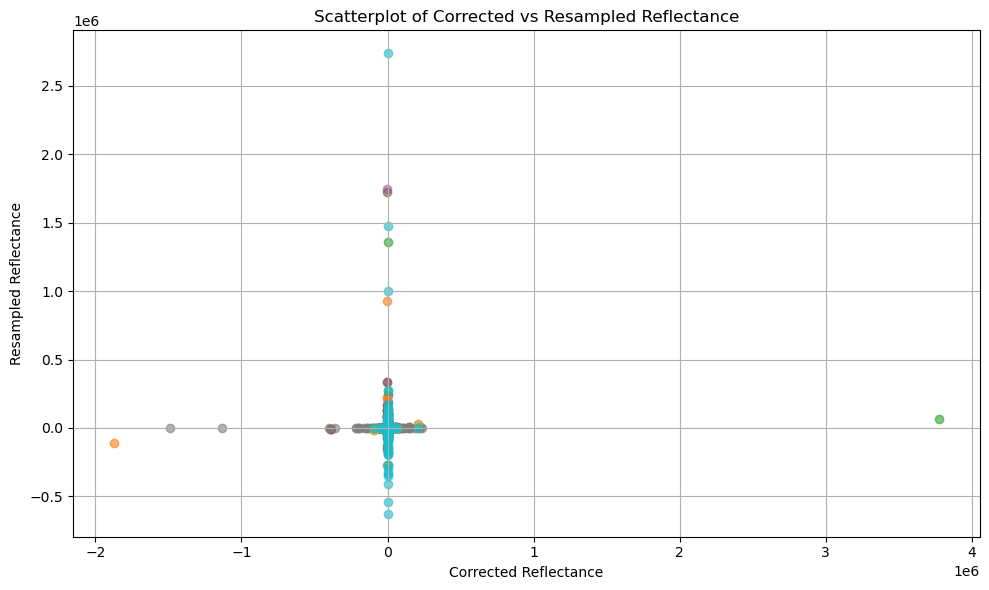

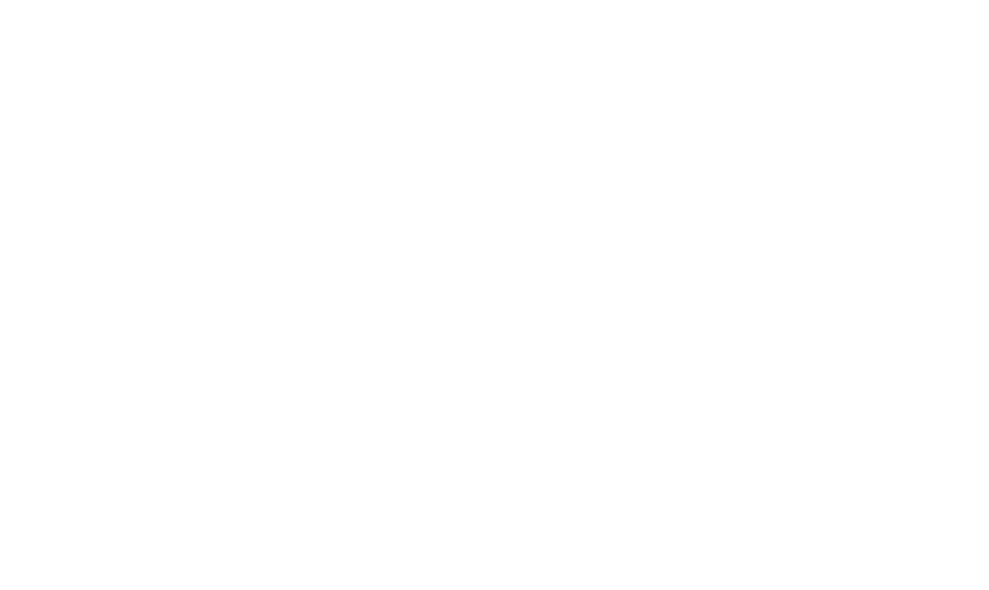

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Path to the cleaned CSV file
cleaned_csv = "Next_try/NEON_D13_NIWO_DP1_20200807_170802_reflectance/NEON_D13_NIWO_DP1_20200807_170802_reflectance_spectral_data_all_sensors_no_NaN.csv"

# Load the data
data = pd.read_csv(cleaned_csv)

# Extract relevant columns
corrected_columns = [col for col in data.columns if "Corrected_band" in col]
resampled_columns = [col for col in data.columns if "Landsat" in col or "MicaSense" in col]

# Extract wavelengths from column names
def extract_wavelength(column_name):
    return float(column_name.split('_')[-1].replace("nm", "").replace("wl", ""))

corrected_wavelengths = {col: extract_wavelength(col) for col in corrected_columns}
resampled_wavelengths = {col: extract_wavelength(col) for col in resampled_columns}

# Match resampled columns to the closest corrected columns by wavelength
matches = {}
for resampled_col, resampled_wl in resampled_wavelengths.items():
    closest_corrected_col = min(corrected_wavelengths, key=lambda x: abs(corrected_wavelengths[x] - resampled_wl))
    matches[resampled_col] = closest_corrected_col

# Prepare the plot
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(matches)))  # Different colors for each resampled type

legend_entries = []
for i, (resampled_col, corrected_col) in enumerate(matches.items()):
    plt.scatter(data[corrected_col], data[resampled_col], label=f"{resampled_col} vs {corrected_col}", alpha=0.6, color=colors[i])
    legend_entries.append(f"{resampled_col} vs {corrected_col}")

plt.xlabel("Corrected Reflectance")
plt.ylabel("Resampled Reflectance")
plt.title("Scatterplot of Corrected vs Resampled Reflectance")
plt.grid(True)
plt.tight_layout()

# Save the scatterplot
plt.savefig("scatterplot_corrected_vs_resampled.png")

# Save the legend as a separate figure
fig_legend = plt.figure(figsize=(10, 6))
fig_legend.legend(handles=plt.gca().collections, labels=legend_entries, loc="center", frameon=False)
plt.axis("off")
fig_legend.tight_layout()
fig_legend.savefig("legend_corrected_vs_resampled.png")

# Show the scatterplot
plt.show()


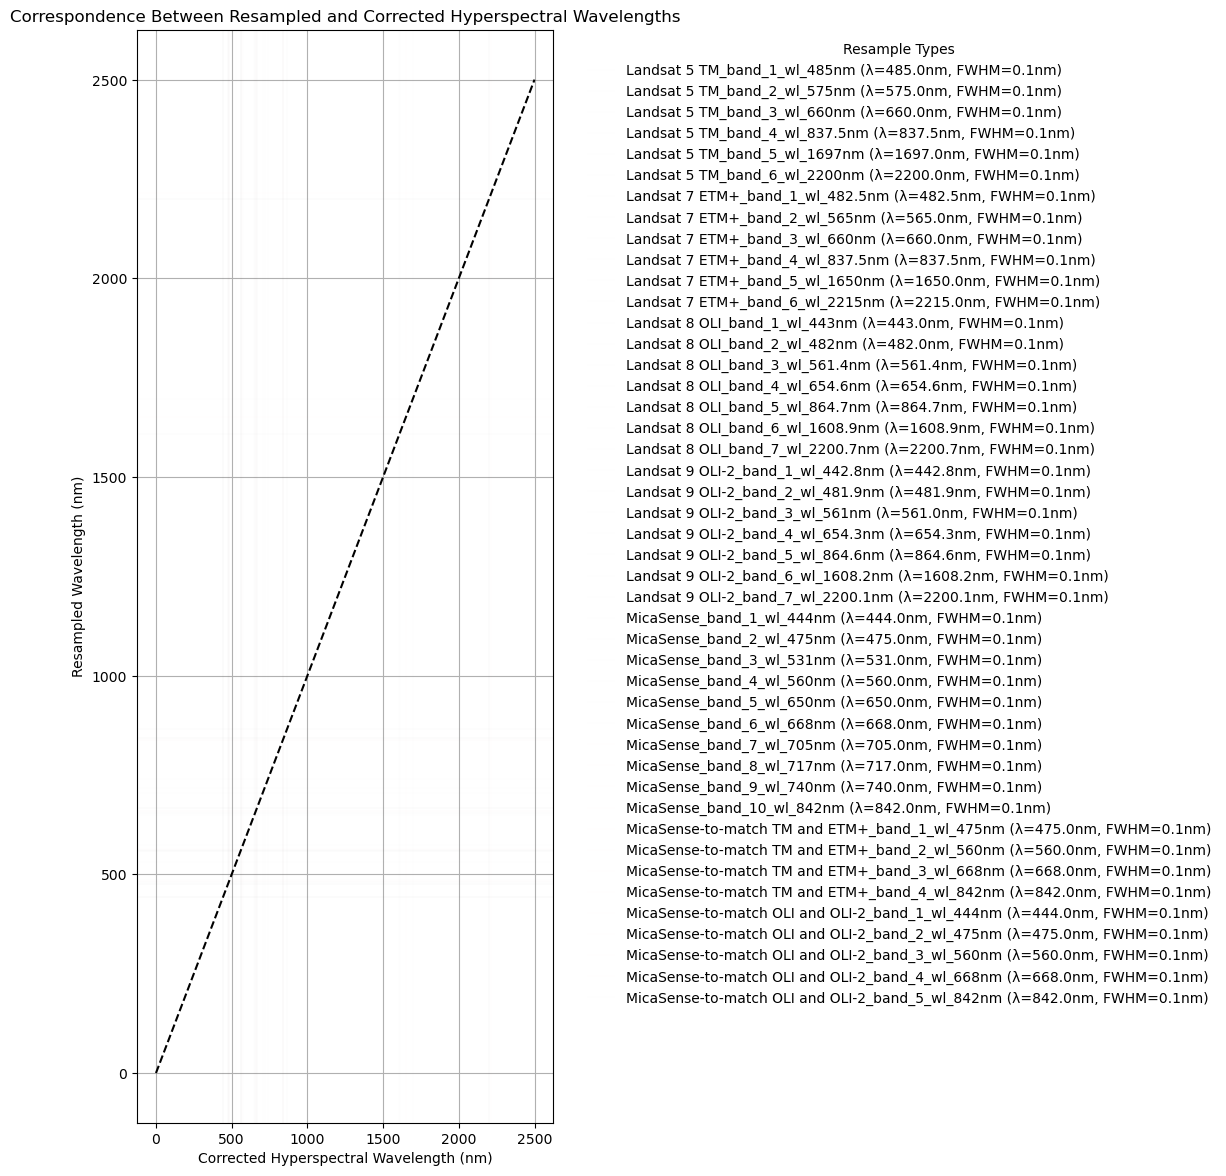

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

# Path to the cleaned CSV file
cleaned_csv = "Next_try/NEON_D13_NIWO_DP1_20200807_170802_reflectance/NEON_D13_NIWO_DP1_20200807_170802_reflectance_spectral_data_all_sensors_no_NaN.csv"

# Path to the JSON file
band_params_file = "Resampling/landsat_band_parameters.json"

# Load the column names only
data_columns = pd.read_csv(cleaned_csv, nrows=0).columns

# Extract relevant columns
corrected_columns = [col for col in data_columns if "Corrected_band" in col]
resampled_columns = [col for col in data_columns if "Landsat" in col or "MicaSense" in col]

# Extract wavelengths from column names
def extract_wavelength(column_name):
    return float(column_name.split('_')[-1].replace("nm", "").replace("wl", ""))

corrected_wavelengths = {col: extract_wavelength(col) for col in corrected_columns}
resampled_wavelengths = {col: extract_wavelength(col) for col in resampled_columns}

# Load FWHM values from JSON
with open(band_params_file, 'r') as f:
    fwhm_data = json.load(f)

# Verify JSON structure
def get_fwhm(sensor_name, band_name):
    # Find the matching sensor in the JSON
    sensor_data = fwhm_data.get(sensor_name)
    if not sensor_data:
        return 0.1  # Default minimum FWHM if the sensor is not found
    # Match the band within the sensor
    try:
        band_index = sensor_data['wavelengths'].index(float(band_name))
        return sensor_data['fwhms'][band_index]
    except ValueError:
        return 0.1  # Default minimum FWHM if the band is not found

# Categorize resampled columns by sensor type
sensor_types = {}
for col in resampled_columns:
    sensor_name = col.split('_')[0]  # Extract sensor name (e.g., "Landsat 5")
    if sensor_name not in sensor_types:
        sensor_types[sensor_name] = []
    sensor_types[sensor_name].append(col)

# Prepare the plot
plt.figure(figsize=(12, 12))
colors = plt.cm.tab10(np.linspace(0, 1, len(sensor_types)))  # Unique colors for each sensor type

# Plot MicaSense as a base layer
if "MicaSense" in sensor_types:
    base_color = "gray"
    for col in sensor_types["MicaSense"]:
        wl = resampled_wavelengths[col]
        fwhm = get_fwhm("MicaSense", col.split('_')[-1])
        plt.axvline(x=wl, color=base_color, linestyle="--", linewidth=fwhm / 10, alpha=0.3)
        plt.axhline(y=wl, color=base_color, linestyle="--", linewidth=fwhm / 10, alpha=0.3)

# Plot the other sensor types
for i, (sensor_name, columns) in enumerate(sensor_types.items()):
    if sensor_name == "MicaSense":
        continue  # Skip MicaSense (already plotted as base layer)
    for col in columns:
        wl = resampled_wavelengths[col]
        fwhm = get_fwhm(sensor_name, col.split('_')[-1])
        plt.axvline(x=wl, color=colors[i], linestyle="--", linewidth=fwhm / 10, alpha=0.5)
        plt.axhline(y=wl, color=colors[i], linestyle="--", linewidth=fwhm / 10, alpha=0.5)

# Highlight MicaSense-to-match
if "MicaSense-to-match" in sensor_types:
    highlight_color = "red"
    for col in sensor_types["MicaSense-to-match"]:
        wl = resampled_wavelengths[col]
        fwhm = get_fwhm("MicaSense", col.split('_')[-1])
        plt.axvline(x=wl, color=highlight_color, linestyle="-", linewidth=fwhm / 5, alpha=0.8)
        plt.axhline(y=wl, color=highlight_color, linestyle="-", linewidth=fwhm / 5, alpha=0.8)

# Add 1:1 line for reference
plt.plot([0, 2500], [0, 2500], color="black", linestyle="--", label="1:1 Line")

# Labels and title
plt.xlabel("Corrected Hyperspectral Wavelength (nm)")
plt.ylabel("Resampled Wavelength (nm)")
plt.title("Correspondence Between Resampled and Corrected Hyperspectral Wavelengths")
plt.grid(True)

# Legend for resample types
legend_labels = []
for sensor_name, columns in sensor_types.items():
    for col in columns:
        wl = resampled_wavelengths[col]
        fwhm = get_fwhm(sensor_name, col.split('_')[-1])
        legend_labels.append(f"{col} (λ={wl}nm, FWHM={fwhm}nm)")
plt.legend(legend_labels, loc="upper left", bbox_to_anchor=(1.05, 1), title="Resample Types", frameon=False)

plt.tight_layout()
plt.savefig("resampled_vs_corrected_wavelength_with_fwhm_optimized.png")
plt.show()


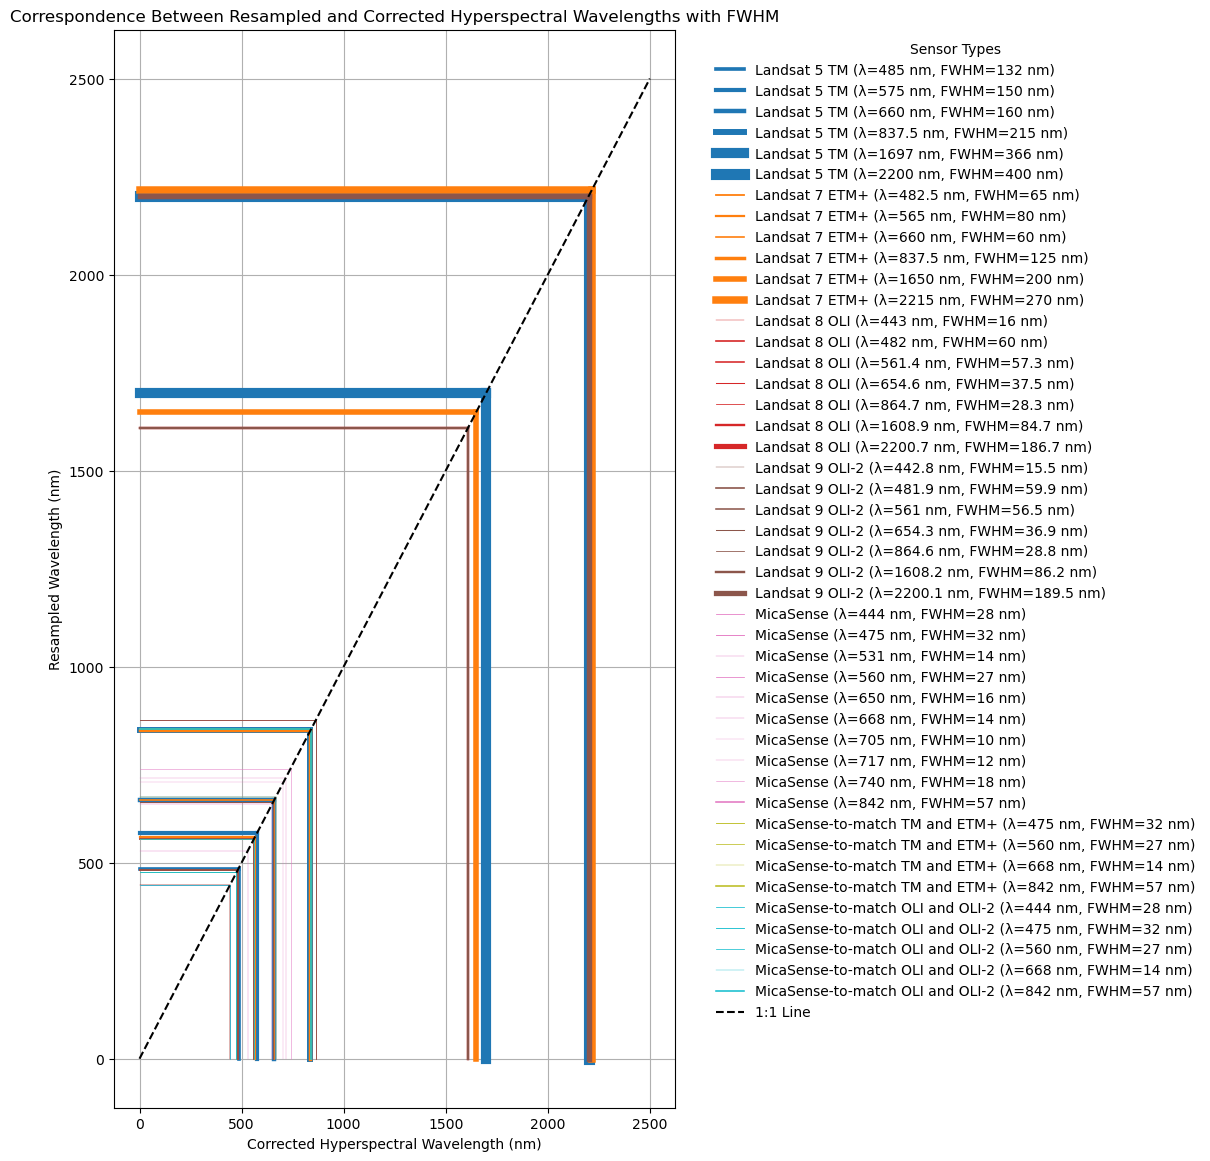

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

# Path to the JSON file
band_params_file = "Resampling/landsat_band_parameters.json"

# Load the JSON file
with open(band_params_file, 'r') as f:
    band_params = json.load(f)

# Extract band parameters
sensor_data = {}
for sensor, params in band_params.items():
    sensor_data[sensor] = {
        'wavelengths': params['wavelengths'],
        'fwhms': params['fwhms']
    }

# Prepare the plot
plt.figure(figsize=(12, 12))
colors = plt.cm.tab10(np.linspace(0, 1, len(sensor_data)))  # Unique colors for each sensor type

for i, (sensor, data) in enumerate(sensor_data.items()):
    wavelengths = data['wavelengths']
    fwhms = data['fwhms']

    for wl, fwhm in zip(wavelengths, fwhms):
        # Vertical line for the wavelength range based on FWHM
        plt.plot([wl, wl], [0, wl], color=colors[i], linewidth=fwhm / 50, label=f"{sensor} (λ={wl} nm, FWHM={fwhm} nm)")
        # Horizontal line for the wavelength range based on FWHM
        plt.plot([0, wl], [wl, wl], color=colors[i], linewidth=fwhm / 50)

# Add 1:1 line for reference
plt.plot([0, 2500], [0, 2500], color="black", linestyle="--", label="1:1 Line")

# Labels and title
plt.xlabel("Corrected Hyperspectral Wavelength (nm)")
plt.ylabel("Resampled Wavelength (nm)")
plt.title("Correspondence Between Resampled and Corrected Hyperspectral Wavelengths with FWHM")
plt.grid(True)

# Custom legend for each sensor type
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = {label: handle for handle, label in zip(handles, labels)}
plt.legend(unique_labels.values(), unique_labels.keys(), loc="upper left", bbox_to_anchor=(1.05, 1), title="Sensor Types", frameon=False)

plt.tight_layout()
plt.savefig("resampled_vs_corrected_wavelength_with_fwhm.png")
plt.show()


Loading and sampling data...
Processed chunk 1: Sampled 10000 rows.
Total sampled rows: 10000
Panel plot saved as 'panel_plot.png'.


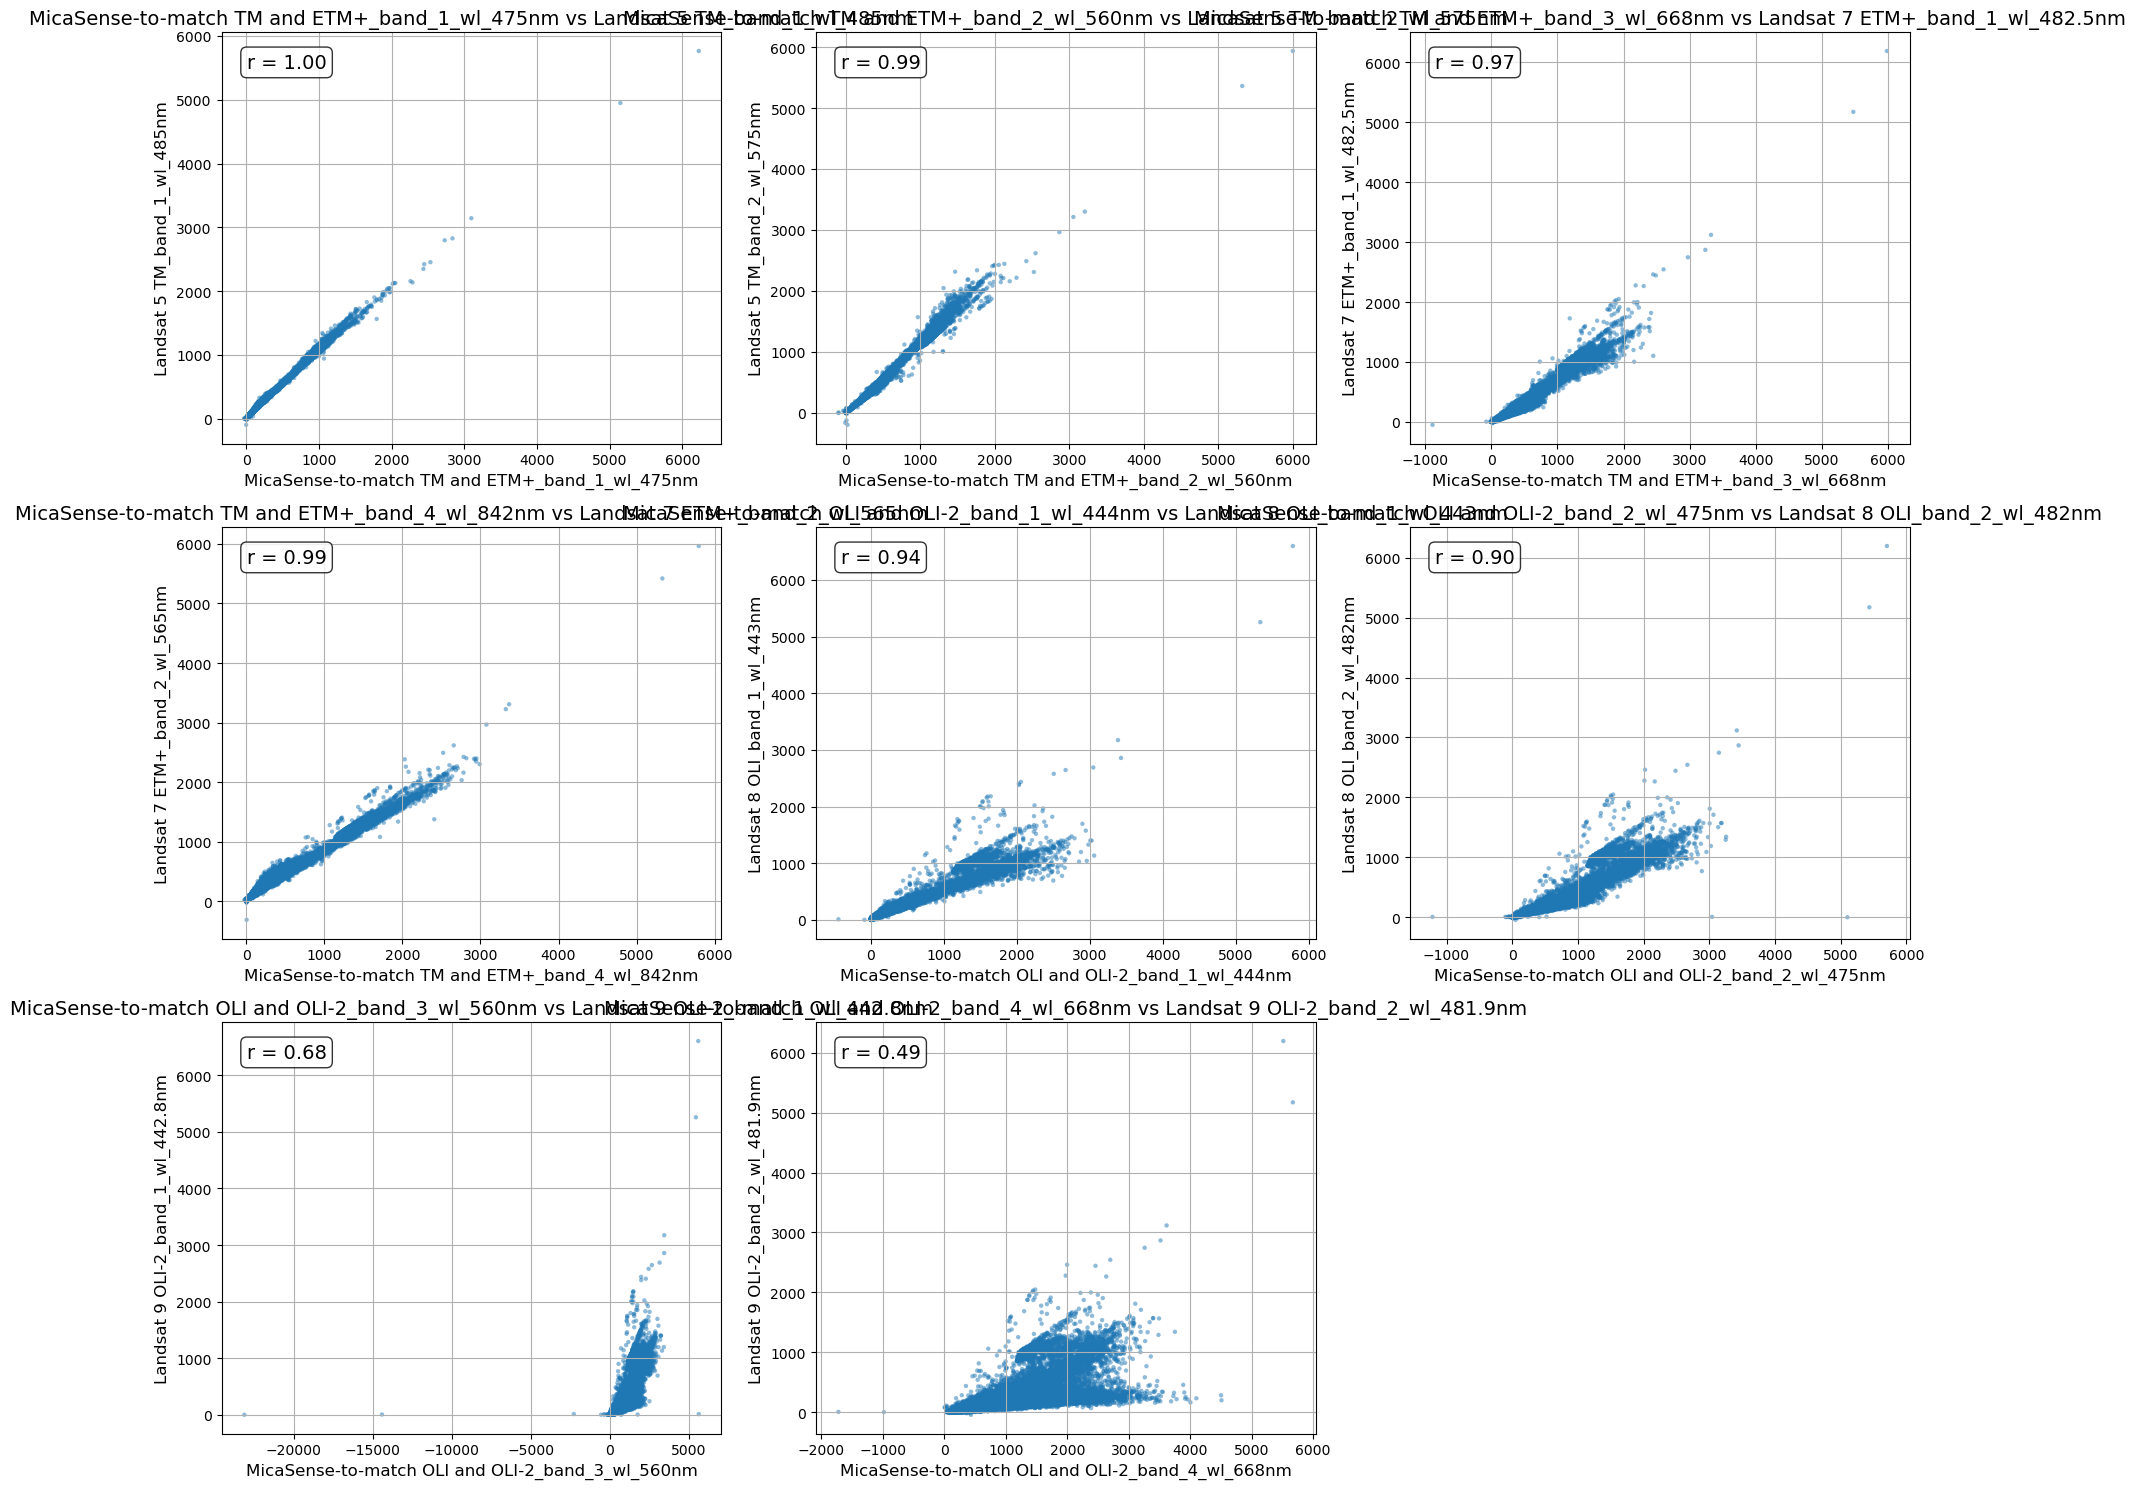

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import pearsonr

# -----------------------------
# Step 1: Define Band Mappings
# -----------------------------
# Update this dictionary based on your actual band correspondences
band_mappings = {
    # Landsat 5 TM Mapped Bands
    'Landsat 5 TM_band_1_wl_485nm': 'MicaSense-to-match TM and ETM+_band_1_wl_475nm',
    'Landsat 5 TM_band_2_wl_575nm': 'MicaSense-to-match TM and ETM+_band_2_wl_560nm',
    # Add all Landsat 5 TM band mappings here
    
    # Landsat 7 ETM+ Mapped Bands
    'Landsat 7 ETM+_band_1_wl_482.5nm': 'MicaSense-to-match TM and ETM+_band_3_wl_668nm',
    'Landsat 7 ETM+_band_2_wl_565nm': 'MicaSense-to-match TM and ETM+_band_4_wl_842nm',
    # Add all Landsat 7 ETM+ band mappings here
    
    # Landsat 8 OLI Mapped Bands
    'Landsat 8 OLI_band_1_wl_443nm': 'MicaSense-to-match OLI and OLI-2_band_1_wl_444nm',
    'Landsat 8 OLI_band_2_wl_482nm': 'MicaSense-to-match OLI and OLI-2_band_2_wl_475nm',
    # Add all Landsat 8 OLI band mappings here
    
    # Landsat 9 OLI-2 Mapped Bands
    'Landsat 9 OLI-2_band_1_wl_442.8nm': 'MicaSense-to-match OLI and OLI-2_band_3_wl_560nm',
    'Landsat 9 OLI-2_band_2_wl_481.9nm': 'MicaSense-to-match OLI and OLI-2_band_4_wl_668nm',
    # Add all Landsat 9 OLI-2 band mappings here
}

# -----------------------------
# Step 2: Identify Relevant Columns
# -----------------------------
# Define the path to your CSV file
file_path = "Next_try/NEON_D13_NIWO_DP1_20200807_170802_reflectance/NEON_D13_NIWO_DP1_20200807_170802_reflectance_spectral_data_all_sensors_no_NaN.csv"

# Extract all Landsat and MicaSense columns from the mapping
landsat_cols = list(band_mappings.keys())
micasense_cols = list(band_mappings.values())

# Combine all relevant columns
relevant_cols = landsat_cols + micasense_cols

# Optionally, include identifier columns if needed (e.g., Pixel_id)
# relevant_cols += ['Pixel_id']  # Uncomment if needed

# -----------------------------
# Step 3: Load and Sample Data
# -----------------------------
# Define the number of samples you want (e.g., 10,000)
desired_sample_size = 10000

# Initialize list to hold sampled data
sampled_data = []

# Define chunk size based on your system's memory capacity
chunk_size = 100000  # Adjust as necessary

print("Loading and sampling data...")

# Read the CSV in chunks
for chunk_number, chunk in enumerate(pd.read_csv(file_path, usecols=relevant_cols, chunksize=chunk_size)):
    # Drop rows where all relevant columns are NaN
    chunk.dropna(axis=0, how='all', subset=relevant_cols, inplace=True)
    
    # Further drop rows with NaN in any of the relevant columns to ensure clean comparisons
    chunk.dropna(axis=0, how='any', subset=landsat_cols + micasense_cols, inplace=True)
    
    # Determine the number of samples to take from this chunk
    remaining_samples = desired_sample_size - len(sampled_data)
    if remaining_samples <= 0:
        break  # Desired sample size achieved
    
    # If the chunk has more rows than needed, sample only the remaining
    if len(chunk) > remaining_samples:
        sampled_chunk = chunk.sample(n=remaining_samples, random_state=42)
    else:
        sampled_chunk = chunk
    
    sampled_data.append(sampled_chunk)
    
    print(f"Processed chunk {chunk_number + 1}: Sampled {len(sampled_chunk)} rows.")
    
    # Update the desired sample size
    desired_sample_size -= len(sampled_chunk)

# Concatenate all sampled chunks into a single DataFrame
if sampled_data:
    data = pd.concat(sampled_data, ignore_index=True)
    print(f"Total sampled rows: {len(data)}")
else:
    raise ValueError("No data was sampled. Check your column mappings and CSV file.")

# -----------------------------
# Step 4: Create Panel Plots with Correlation Coefficients
# -----------------------------
# Determine the number of plots
num_plots = len(band_mappings)

# Define grid size for subplots (e.g., 3 columns)
cols = 3
rows = math.ceil(num_plots / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()  # Flatten to easily iterate

# Iterate over each band mapping and create scatter plots
for idx, (landsat_band, micasense_band) in enumerate(band_mappings.items()):
    ax = axes[idx]
    
    # Extract data for plotting
    x = data[micasense_band]
    y = data[landsat_band]
    
    # Plot scatter
    scatter = ax.scatter(x, y, alpha=0.5, s=10, edgecolor='none')
    
    # Calculate Pearson correlation coefficient
    if len(x) > 1:
        corr_coef, p_value = pearsonr(x, y)
        corr_text = f"r = {corr_coef:.2f}"
    else:
        corr_text = "r = N/A"
    
    # Display the correlation coefficient on the plot
    ax.text(0.05, 0.95, corr_text, transform=ax.transAxes,
            fontsize=14, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Set labels and title
    ax.set_xlabel(micasense_band, fontsize=12)
    ax.set_ylabel(landsat_band, fontsize=12)
    ax.set_title(f"{micasense_band} vs {landsat_band}", fontsize=14)
    
    # Improve layout
    ax.grid(True)

# Remove any unused subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# -----------------------------
# Step 5: Save the Plot as PNG
# -----------------------------
output_filename = "panel_plot.png"  # Specify your desired output filename
plt.savefig(output_filename, dpi=300)
print(f"Panel plot saved as '{output_filename}'.")

# Optionally, display the plot
plt.show()


Loading and sampling data...
Processed chunk 1: Sampled 10000 rows.
Total sampled rows: 10000
Panel plot saved as 'panel_plot.png'.
Regression coefficients saved as 'linear_regression_coefficients.csv'.


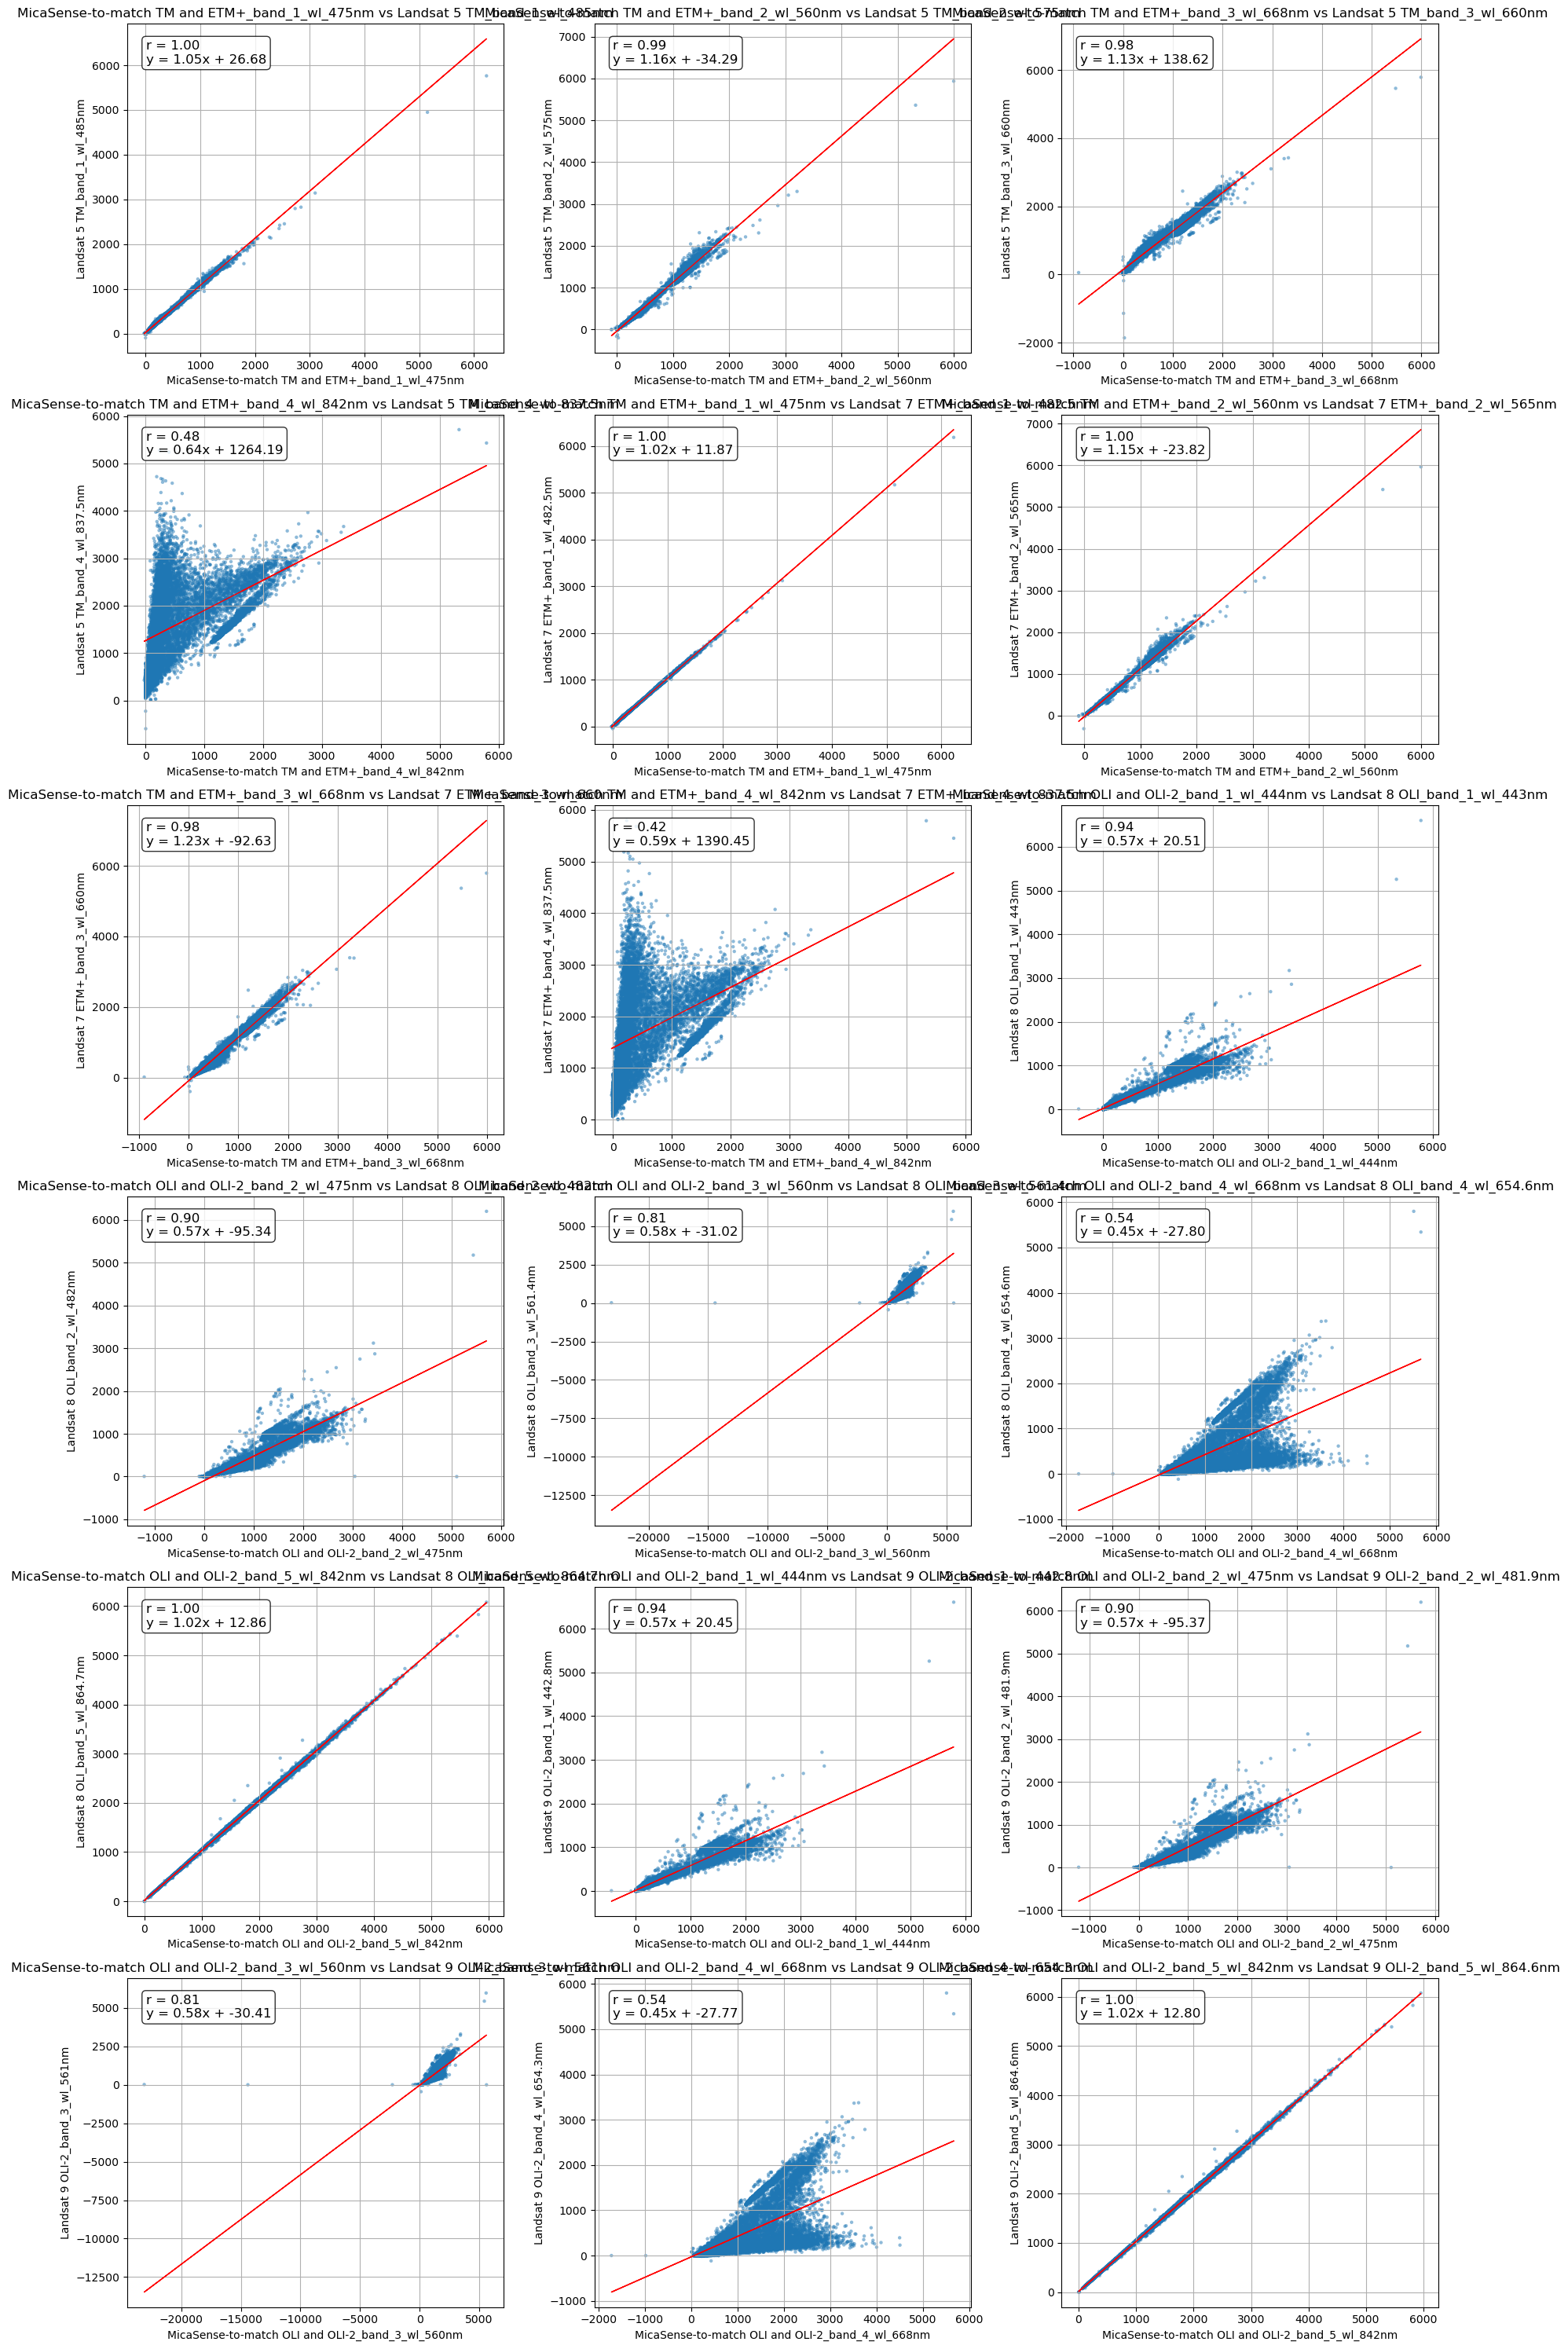

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import pearsonr

# -----------------------------
# Step 1: Define Band Mappings
# -----------------------------
band_mappings = {
    # -----------------------------
    # Landsat 5 TM Mapped Bands
    # -----------------------------
    'Landsat 5 TM_band_1_wl_485nm': 'MicaSense-to-match TM and ETM+_band_1_wl_475nm',
    'Landsat 5 TM_band_2_wl_575nm': 'MicaSense-to-match TM and ETM+_band_2_wl_560nm',
    'Landsat 5 TM_band_3_wl_660nm': 'MicaSense-to-match TM and ETM+_band_3_wl_668nm',
    'Landsat 5 TM_band_4_wl_837.5nm': 'MicaSense-to-match TM and ETM+_band_4_wl_842nm',

    # -----------------------------
    # Landsat 7 ETM+ Mapped Bands
    # -----------------------------
    'Landsat 7 ETM+_band_1_wl_482.5nm': 'MicaSense-to-match TM and ETM+_band_1_wl_475nm',
    'Landsat 7 ETM+_band_2_wl_565nm': 'MicaSense-to-match TM and ETM+_band_2_wl_560nm',
    'Landsat 7 ETM+_band_3_wl_660nm': 'MicaSense-to-match TM and ETM+_band_3_wl_668nm',
    'Landsat 7 ETM+_band_4_wl_837.5nm': 'MicaSense-to-match TM and ETM+_band_4_wl_842nm',

    # -----------------------------
    # Landsat 8 OLI Mapped Bands
    # -----------------------------
    'Landsat 8 OLI_band_1_wl_443nm': 'MicaSense-to-match OLI and OLI-2_band_1_wl_444nm',
    'Landsat 8 OLI_band_2_wl_482nm': 'MicaSense-to-match OLI and OLI-2_band_2_wl_475nm',
    'Landsat 8 OLI_band_3_wl_561.4nm': 'MicaSense-to-match OLI and OLI-2_band_3_wl_560nm',
    'Landsat 8 OLI_band_4_wl_654.6nm': 'MicaSense-to-match OLI and OLI-2_band_4_wl_668nm',
    'Landsat 8 OLI_band_5_wl_864.7nm': 'MicaSense-to-match OLI and OLI-2_band_5_wl_842nm',

    # -----------------------------
    # Landsat 9 OLI-2 Mapped Bands
    # -----------------------------
    'Landsat 9 OLI-2_band_1_wl_442.8nm': 'MicaSense-to-match OLI and OLI-2_band_1_wl_444nm',
    'Landsat 9 OLI-2_band_2_wl_481.9nm': 'MicaSense-to-match OLI and OLI-2_band_2_wl_475nm',
    'Landsat 9 OLI-2_band_3_wl_561nm': 'MicaSense-to-match OLI and OLI-2_band_3_wl_560nm',
    'Landsat 9 OLI-2_band_4_wl_654.3nm': 'MicaSense-to-match OLI and OLI-2_band_4_wl_668nm',
    'Landsat 9 OLI-2_band_5_wl_864.6nm': 'MicaSense-to-match OLI and OLI-2_band_5_wl_842nm',
}

# -----------------------------
# Step 2: Identify Relevant Columns
# -----------------------------
# Define the path to your CSV file
file_path = "Next_try/NEON_D13_NIWO_DP1_20200807_170802_reflectance/NEON_D13_NIWO_DP1_20200807_170802_reflectance_spectral_data_all_sensors_no_NaN.csv"

# Extract all Landsat and MicaSense columns from the mapping
landsat_cols = list(band_mappings.keys())
micasense_cols = list(band_mappings.values())

# Combine all relevant columns
relevant_cols = landsat_cols + micasense_cols

# Optionally, include identifier columns if needed (e.g., Pixel_id)
# relevant_cols += ['Pixel_id']  # Uncomment if needed

# -----------------------------
# Step 3: Load and Sample Data
# -----------------------------
# Define the number of samples you want (e.g., 10,000)
desired_sample_size = 10000

# Initialize list to hold sampled data
sampled_data = []

# Define chunk size based on your system's memory capacity
chunk_size = 100000  # Adjust as necessary

print("Loading and sampling data...")

# Read the CSV in chunks
for chunk_number, chunk in enumerate(pd.read_csv(file_path, usecols=relevant_cols, chunksize=chunk_size)):
    # Drop rows where all relevant columns are NaN
    chunk.dropna(axis=0, how='all', subset=relevant_cols, inplace=True)
    
    # Further drop rows with NaN in any of the relevant columns to ensure clean comparisons
    chunk.dropna(axis=0, how='any', subset=landsat_cols + micasense_cols, inplace=True)
    
    # Determine the number of samples to take from this chunk
    remaining_samples = desired_sample_size - len(sampled_data)
    if remaining_samples <= 0:
        break  # Desired sample size achieved
    
    # If the chunk has more rows than needed, sample only the remaining
    if len(chunk) > remaining_samples:
        sampled_chunk = chunk.sample(n=remaining_samples, random_state=42)
    else:
        sampled_chunk = chunk
    
    sampled_data.append(sampled_chunk)
    
    print(f"Processed chunk {chunk_number + 1}: Sampled {len(sampled_chunk)} rows.")
    
    # Update the desired sample size
    desired_sample_size -= len(sampled_chunk)

# Concatenate all sampled chunks into a single DataFrame
if sampled_data:
    data = pd.concat(sampled_data, ignore_index=True)
    print(f"Total sampled rows: {len(data)}")
else:
    raise ValueError("No data was sampled. Check your column mappings and CSV file.")

# -----------------------------
# Step 4: Create Panel Plots with Correlation Coefficients and Regression Lines
# -----------------------------
# Determine the number of plots
num_plots = len(band_mappings)

# Define grid size for subplots (e.g., 3 columns)
cols = 3
rows = math.ceil(num_plots / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()  # Flatten to easily iterate

# Initialize a list to store regression coefficients
regression_coefficients = []

# Iterate over each band mapping and create scatter plots
for idx, (landsat_band, micasense_band) in enumerate(band_mappings.items()):
    ax = axes[idx]
    
    # Extract data for plotting
    x = data[micasense_band]
    y = data[landsat_band]
    
    # Plot scatter
    scatter = ax.scatter(x, y, alpha=0.5, s=10, edgecolor='none')
    
    # Initialize variables
    corr_text = "r = N/A"
    regression_text = "y = N/A"
    slope, intercept = np.nan, np.nan
    
    # Calculate Pearson correlation coefficient and linear regression if sufficient data
    if len(x) > 1:
        corr_coef, p_value = pearsonr(x, y)
        corr_text = f"r = {corr_coef:.2f}"
        
        # Calculate linear regression (slope and intercept)
        slope, intercept = np.polyfit(x, y, 1)
        regression_text = f"y = {slope:.2f}x + {intercept:.2f}"
        
        # Plot regression line
        ax.plot(x, slope * x + intercept, color='red', linewidth=1)
    
    # Display the correlation coefficient and regression equation on the plot
    combined_text = f"{corr_text}\n{regression_text}"
    ax.text(0.05, 0.95, combined_text, transform=ax.transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Set labels and title
    ax.set_xlabel(micasense_band, fontsize=10)
    ax.set_ylabel(landsat_band, fontsize=10)
    ax.set_title(f"{micasense_band} vs {landsat_band}", fontsize=12)
    
    # Improve layout
    ax.grid(True)
    
    # Append the coefficients to the list
    regression_coefficients.append({
        'Landsat Band': landsat_band,
        'MicaSense Band': micasense_band,
        'Pearson r': corr_coef if len(x) > 1 else np.nan,
        'Slope': slope,
        'Y-Intercept': intercept
    })

# Remove any unused subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# -----------------------------
# Step 5: Save the Plot as PNG
# -----------------------------
output_plot_filename = "panel_plot.png"  # Specify your desired output filename
plt.savefig(output_plot_filename, dpi=300)
print(f"Panel plot saved as '{output_plot_filename}'.")

# -----------------------------
# Step 6: Save Regression Coefficients to CSV
# -----------------------------
# Create a DataFrame from the coefficients list
coefficients_df = pd.DataFrame(regression_coefficients)

# Save the DataFrame to a CSV file
output_coefficients_filename = "linear_regression_coefficients.csv"
coefficients_df.to_csv(output_coefficients_filename, index=False)
print(f"Regression coefficients saved as '{output_coefficients_filename}'.")

# Optionally, display the plot
plt.show()


### What Happens When `jefe` Runs

When you run the `jefe` function, a sequence of operations is executed, and multiple outputs are generated. Here's a detailed breakdown:

1. **Downloading Raw Data:**
   - The original NEON flight line folder is downloaded to the specified output directory.
   - The raw folder contains the reflectance data and associated metadata files.

2. **Conversion to Multiple Formats:**
   - The downloaded folder is processed to generate additional formats required for analysis.
   - These files are named systematically to represent the processing step or correction applied. For example:
     - **`_envi`:** Reflectance data in ENVI format.
     - **`_envi_mask`:** Mask files indicating areas to include or exclude during analysis.
     - **`.hdr`:** Header files describing the structure of the associated data.
     - **`.json`:** Configuration files for corrections and processing steps.

3. **Application of Corrections:**
   - Topographic corrections (TOPO) and bidirectional reflectance distribution function (BRDF) corrections are applied to ensure data accuracy.
   - Outputs include:
     - **`_brdf_coeffs__envi.json`:** Coefficients for BRDF corrections.
     - **`_topo_coeffs__envi.json`:** Coefficients for topographic corrections.

4. **Data Extraction and Processing:**
   - Spectral data is extracted pixel by pixel and saved in tabular formats for further analysis.
   - These extractions are saved incrementally to avoid memory overuse.

---

### Example Outputs from a Single Flight Line

After running the `jefe` function, the output directory contains processed files at the top level and a folder for the original raw data. Here’s what you can expect for a single trial run:

---

#### **Main Output Directory:**
- **Processed Files:** Includes ENVI-format files, masks, headers, and configuration files. These represent the final processed outputs ready for analysis.
- **Raw Folder:** A subdirectory containing the original reflectance data downloaded from NEON.

| File Name                                             | Description                                         |
|-------------------------------------------------------|-----------------------------------------------------|
| `NEON_D13_NIWO_DP1_20200807_170802_reflectance__envi` | Reflectance data converted to ENVI format.         |
| `NEON_D13_NIWO_DP1_20200807_170802_reflectance__mask` | Mask file for the reflectance data.                |
| `NEON_D13_NIWO_DP1_20200807_170802_reflectance.hdr`   | Header file describing the ENVI data structure.    |
| `NEON_D13_NIWO_DP1_20200807_170802_reflectance__brdf_coeffs__envi.json` | BRDF correction coefficients. |
| `NEON_D13_NIWO_DP1_20200807_170802_reflectance__topo_coeffs__envi.json` | TOPO correction coefficients. |

---

#### **Raw Folder (Inside the Output Directory):**
- **Original Files:** Contains the raw reflectance data downloaded directly from NEON before any processing steps.

| File Name                                             | Description                                         |
|-------------------------------------------------------|-----------------------------------------------------|
| `NEON_D13_NIWO_DP1_20200807_170802_reflectance`       | Original reflectance data from NEON.               |
| `NEON_D13_NIWO_DP1_20200807_170802_reflectance_ancillary` | Ancillary metadata for corrections.               |
| `NEON_D13_NIWO_DP1_20200807_170802_reflectance_config__envi.json` | Configuration for ENVI data processing. |
| `NEON_D13_NIWO_DP1_20200807_170802_reflectance_config__anc.json`  | Configuration for ancillary corrections. |

---

This structure ensures that:
1. The **processed files** are readily available in the main directory for analysis.
2. The **raw data** is preserved in its original form for reference or reprocessing if needed.

By organizing outputs this way, you can easily navigate between raw and processed data while maintaining a clear workflow history.


### Process Overview

1. **Data Conversion:**
   - Converts NEON reflectance data to formats compatible with ENVI tools and downstream analyses.

2. **Data Corrections:**
   - Applies topographic and BRDF corrections to improve data quality.

3. **Outputs Generated:**
   - Reflectance data in corrected formats.
   - Mask files for regions of interest.
   - Configuration files describing the processing steps.
   - Coefficients for TOPO and BRDF corrections.

By the end of this process, you will have a comprehensive set of files ready for analysis, including corrected reflectance data, metadata, and configurations.

---

## 6. Handling Large Data Processing<a name="handling-large-data-processing"></a>

Processing NEON flight lines involves managing large amounts of spectral data. This workflow incorporates strategies to optimize memory usage and prevent bottlenecks.

### Key Strategies

1. **Chunk Processing:** Processes data in smaller chunks to avoid memory overload.
2. **Direct Disk Writing:** Saves intermediate and final results directly to storage.
3. **Optimized Data Structures:** Uses efficient formats like NumPy arrays and Pandas DataFrames.
4. **Parallel Processing:** Utilizes libraries like `ray` for distributed processing.

---


## 9. Conclusion<a name="conclusion"></a>

This vignette provided a comprehensive, step-by-step guide to processing NEON flight line data, highlighting key techniques and strategies for handling large, complex datasets. The workflow included downloading NEON flight lines, converting them into suitable file formats, applying critical corrections, and extracting hyperspectral data from pixels before writing the results to CSV files for further numerical analysis.

By completing this process, you gain the ability to transform raw NEON airborne data into actionable datasets, enabling robust ecological and environmental research. This workflow is designed to balance efficiency, accuracy, and scalability, ensuring that even massive datasets can be processed on machines with limited resources.

### **Key Takeaways**
1. **Efficient Data Handling:** 
   - From downloading raw flight line data to saving corrected and processed outputs, this workflow demonstrates how to manage large-scale operations effectively.
   - Chunk processing and direct-to-disk writing ensure that memory constraints are respected while maintaining high data fidelity.

2. **Robust Data Corrections:** 
   - The inclusion of topographic and BRDF corrections ensures that the processed data is accurate and reliable for downstream analysis, accounting for variability in reflectance and terrain.

3. **Hyperspectral Data for Analysis:** 
   - The extraction of hyperspectral data from individual pixels provides a valuable resource for detailed numerical and statistical studies, enabling deeper insights into ecological and environmental processes.

4. **Scalability and Reproducibility:** 
   - This workflow is scalable to handle additional flight lines, datasets, and sites, making it a versatile tool for researchers working across diverse geographies and ecological systems.
   - By following standardized steps and leveraging robust tools, you can ensure that your processing is reproducible and aligned with scientific best practices.

---

## 10. References<a name="references"></a>

- **NEON Data Portal:** [https://data.neonscience.org/](https://data.neonscience.org/)
- **GeoPandas Documentation:** [https://geopandas.org/](https://geopandas.org/)
- **Rasterio Documentation:** [https://rasterio.readthedocs.io/](https://rasterio.readthedocs.io/)
- **NumPy Documentation:** [https://numpy.org/doc/](https://numpy.org/doc/)
- **HyTools Documentation:** [https://hytools.readthedocs.io/](https://hytools.readthedocs.io/)
- **Ray Documentation:** [https://docs.ray.io/en/latest/](https://docs.ray.io/en/latest/)
- **NEON Field Sites Page:** [https://www.neonscience.org/field-sites/explore](https://www.neonscience.org/field-sites/explore)
- **NEON Data Products Catalog:** [https://data.neonscience.org/data-products/explore](https://data.neonscience.org/data-products/explore)
- **NEON Data Availability Page:** [https://data.neonscience.org/visualizations/data-availability](https://data.neonscience.org/visualizations/data-availability)
- **NEON Flight Schedules and Coverage:** [https://www.neonscience.org/data-collection/flight-schedules-coverage](https://www.neonscience.org/data-collection/flight-schedules-coverage)
- **AOP Data Availability Notification:** [https://www.neonscience.org/impact/observatory-blog/aop-data-availability-notification-release-2024](https://www.neonscience.org/impact/observatory-blog/aop-data-availability-notification-release-2024)

---